In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import copy
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 29) (14680,) (1840, 29) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event'],
      dtype='object')


# Random Forest

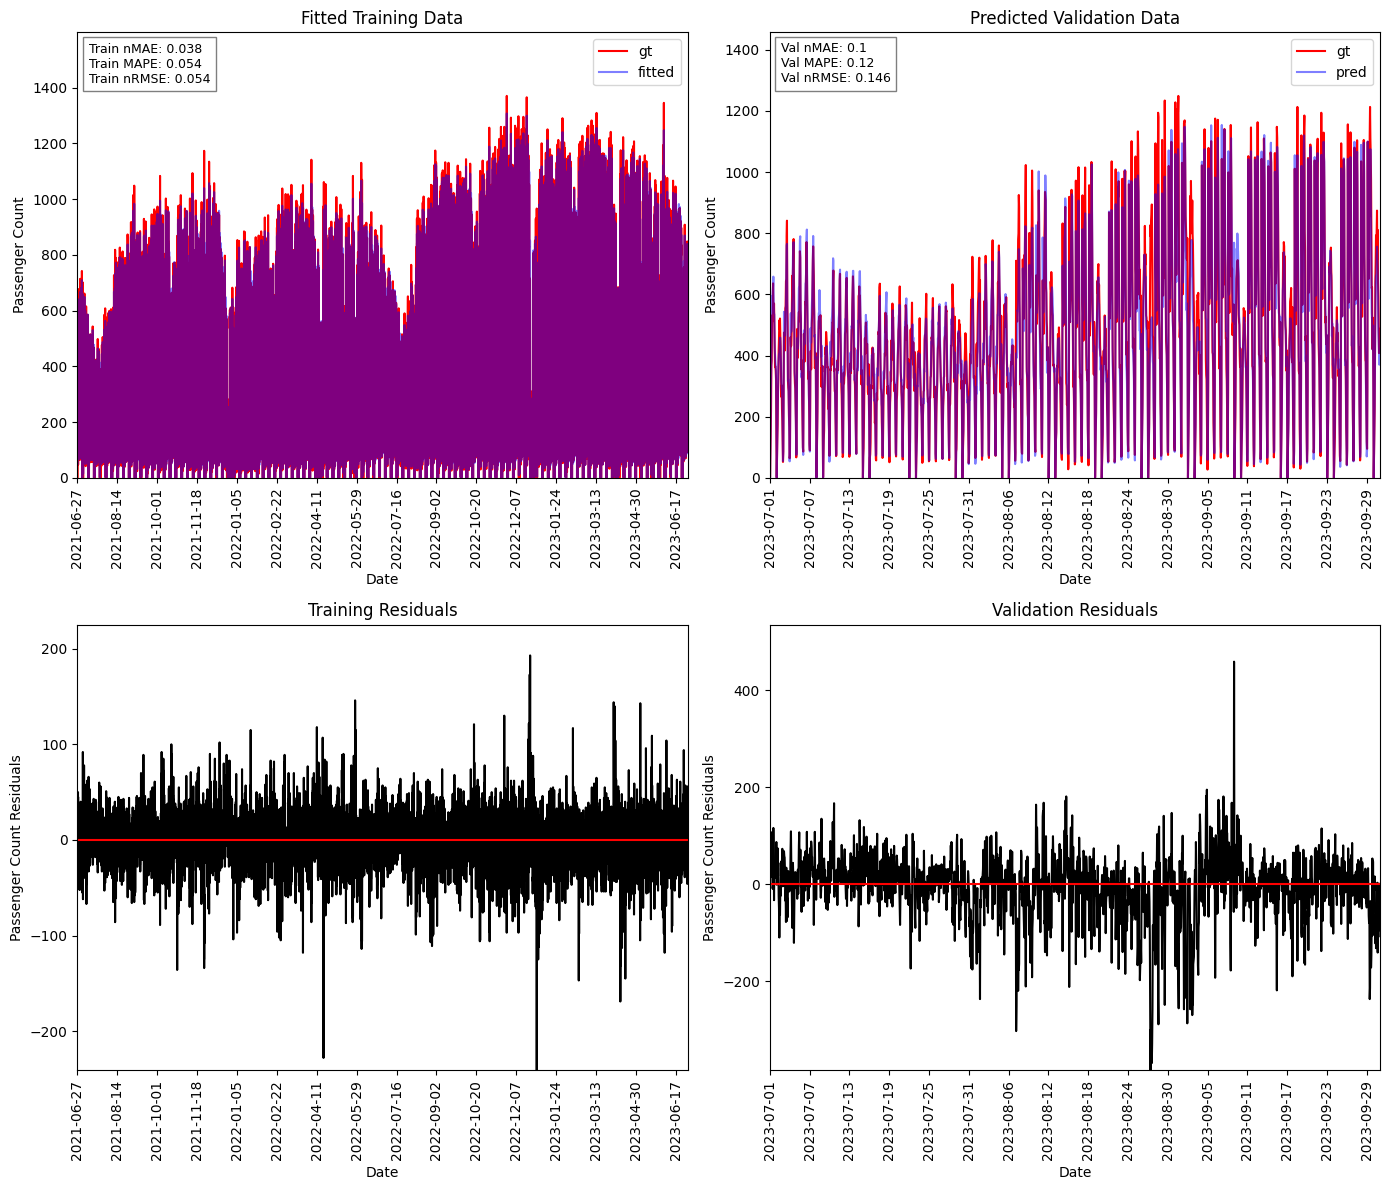

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
RandomForestRegressor(n_estimators=250, random_state=42)


In [4]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20, 40, 60, 80, 100, 120, 140]
differentiation = None
n_estimators = 250

# best 60 min with diff
#lags = [20, 40, 60, 80, 100, 120, 140]
#differentiation = 1
#n_estimators = 250


model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower=None, y_val_upper=None,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

print(model.get_params())
print(model)

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
#                                  y_train_true=y_train, y_val_true=y_val,
#                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
#                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

## Grid search

In [3]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()
#iterator = 0

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for lags in laglist:
                            model = RandomForestRegressor(
                                n_estimators=n_estimators,
                                random_state=42)
                            model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                        
                            trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                            valMAE = nMAE(y=y_val, yhat=y_val_pred)
                            if valMAE < bestMAE:
                                bestMAE = valMAE
                                best_model = model
                                best_y_train_pred = y_train_pred
                                best_y_val_pred = y_val_pred
                                best_lags = lags
                                best_n_estimator = n_estimators
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model, f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{best_model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

1A 60min:

Diff=None

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 100      & None\\
\hline
F-RF-C   & 5      & None\\
\hline
F-RF-CW  & 30      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 100      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 100      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c}
Model    & n\_estimators & Lags\\
\hline
F-RF-W   & 250      & None\\
\hline
F-RF-C   & 50      & None\\
\hline
F-RF-CW  & 250      & None\\
\hline
F-RF-L   & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LW  & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-RF-LC  & 250      & [1, 4, 8, 20, 140]\\
\hline
F-RF-LCW & 250      & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# XGBoost

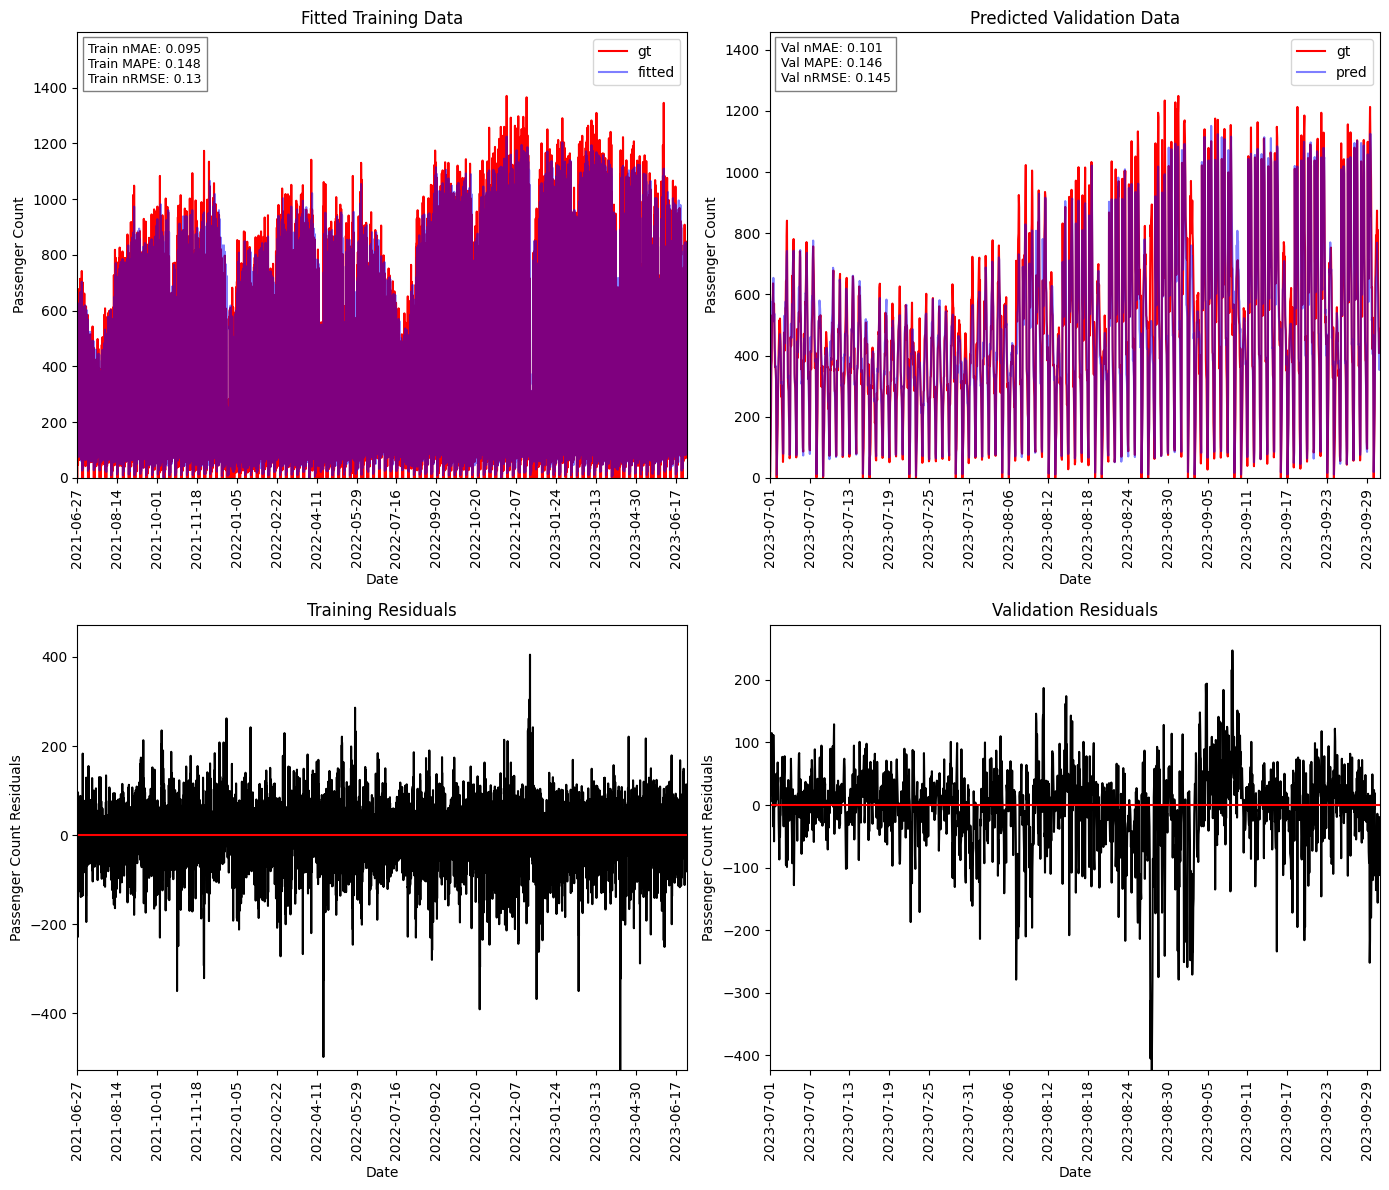

In [9]:
# fixed window 40 hours ahead
horizon = 40*agg

# 2. best 60 min without diff
differentiation = None
lags = [20, 40, 60, 80, 100, 120, 140]
n_estimators = 50
alpha = 0.1
eta = 0.1

# 2. best 60 min with diff
#differentiation = 1
#lags = [20, 40, 60, 80, 100, 120, 140]
#n_estimators = 20
#alpha = 0.0
#eta = 0.2

model = XGBRegressor(n_estimators=n_estimators, alpha=alpha, eta=eta, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None#X_train.shape[0]
use_exog = True
interval = None#[25, 75]

model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
    differentiation=differentiation, lags=lags, window_type=window_type, window_size=window_size,
    interval=interval, horizon=horizon, 
    use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model)

utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred,
                                  y_train_true=y_train, y_val_true=y_val,
                                  y_val_lower=None, y_val_upper=None,
                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

#utils.tools.plotFitAndPredictions(y_train_pred=y_train_pred, y_val_pred=y_val_pred['pred'],
#                                  y_train_true=y_train, y_val_true=y_val,
#                                  y_val_lower= y_val_pred['lower_bound'], y_val_upper= y_val_pred['upper_bound'],
#                                  dates=True, trainDateCol=df_train['date'], valDateCol=df_val['date'])

## Grid search

In [54]:
horizon = 40*agg
window_list = ['fixed']
scalar = StandardScaler()
exog_scalar = StandardScaler()

for window_type in window_list:
    for useLags in [False, True]:
        for dropCalendar in [True, False]:
            for dropWeather in [True, False]:
                for diff in [1, None]:
                    if useLags == False and dropCalendar == True and dropWeather == True:
                        break

                    X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, 
                                                               dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                               dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, 
                                                             dropWeather=dropWeather, dropCalendar=dropCalendar, 
                                                             dropSpecific=[target, Columns.calendar_Q1.value, Columns.calendar_mon.value]) # avoid multicolinearity

                    if useLags:
                        laglist = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                                   [1, 20, 140], 
                                   [1, 4, 8, 20],
                                   [1, 10, 20, 140],
                                   [1, 4, 8, 20, 140],
                                   [20, 40, 60, 80, 100, 120, 140],
                                   [1, 20, 40, 60, 80, 100, 120, 140]]
                        laglist = [[i*agg for i in templist] for templist in laglist]
                    else:
                        laglist = [None]
                    
                    if window_type == 'rolling':
                        window_size = X_train.shape[0]
                    else:
                        window_size = None
                    
                    use_exog = True if dropCalendar == False or dropWeather == False else False

                    bestMAE = 1000000
                    # begin grid search
                    for n_estimators in [5, 10, 20, 30, 50, 100, 250]:
                        for alpha in [0.0, 0.1, 0.2, 0.3, 0.5]:
                            for eta in [0.01, 0.05, 0.1, 0.2, 0.3]: #[]:
                                for lags in laglist:
                                    model = XGBRegressor(n_estimators=n_estimators, 
                                                         eta=eta,
                                                         alpha=alpha, 
                                                         seed=42)
                                    model, y_train_pred, y_val_pred = utils.Sklearn.sklearnForecast(
                                        differentiation=diff, lags=lags, window_type=window_type, window_size=window_size,
                                        horizon=horizon, use_exog=use_exog, scalar=scalar, exog_scalar=exog_scalar,
                                        X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, interval=None)
                                    
                                    trainMAE = nMAE(y=y_train, yhat=y_train_pred)
                                    valMAE = nMAE(y=y_val, yhat=y_val_pred)
                                    if valMAE < bestMAE:
                                        bestMAE = valMAE
                                        best_model = model
                                        best_y_train_pred = y_train_pred
                                        best_y_val_pred = y_val_pred
                                        best_n_estimator = n_estimators
                                        best_alpha = alpha
                                        best_eta = eta
                                        best_lags = lags
                    # end grid search
                    
                    trainMAE = nMAE(y=y_train, yhat=best_y_train_pred)
                    valMAE = nMAE(y=y_val, yhat=best_y_val_pred)
                    trainMAPE = MAPE(y=y_train, yhat=best_y_train_pred)
                    valMAPE = MAPE(y=y_val, yhat=best_y_val_pred)
                    trainRMSE = nRMSE(y=y_train, yhat=best_y_train_pred)
                    valRMSE = nRMSE(y=y_val, yhat=best_y_val_pred)
                    #print('')
                    #print(window_type, f'Lags:{useLags}', f'Drop cal:{dropCalendar}', f'drop Weather:{dropWeather}', f'Diff:{diff}')
                    #print(model.get_xgb_params(), f'Lags:{best_lags}')
                    #print(trainMAE, trainMAPE, trainRMSE)
                    #print(valMAE, valMAPE, valRMSE)
                    with open(f"hyperparameterSearch/{model.__class__.__name__}GridSearch.txt", "a") as f:
                        f.write(f"Window: {window_type}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                        f.write("Best hyperparameters:\n")
                        f.write(f"lags: {best_lags}\n")
                        f.write(f"n_estimators {best_n_estimator}, alpha L1: {best_alpha}, eta: {best_eta}\n")
                        f.write(f"Train metrics:\n")
                        f.write(f"nMAE: {trainMAE}, MAPE: {trainMAPE}, nRMSE: {trainRMSE}\n")
                        f.write(f"Val metrics:\n")
                        f.write(f"nMAE: {valMAE}, MAPE: {valMAPE}, nRMSE: {valRMSE}\n")
                        f.write("------------------------------------------------------------------------------\n")

1A 60min:

Diff=None

$$
\begin{array}{c|c|c|c|c}
Model     & n\_estimators & \alpha L1 & \eta & Lags\\
\hline
F-XGB-W   & 10            & 0.3       & 0.2  & None\\
\hline
F-XGB-C   & 10            & 0.0       & 0.2  & None\\
\hline
F-XGB-CW  & 10            & 0.1       & 0.3  & None\\
\hline
F-XGB-L   & 100           & 0.5       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LW  & 100           & 0.0       & 0.05 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LC  & 100           & 0.3       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LCW & 50            & 0.1       & 0.1  & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c|c|c}
Model     & n\_estimators & \alpha (L1) & \eta & Lags\\
\hline
F-XGB-W   & 5             & 0.2       & 0.3  & None\\
\hline
F-XGB-C   & 20            & 0.3       & 0.2  & None\\
\hline
F-XGB-CW  & 100           & 0.2       & 0.1  & None\\
\hline
F-XGB-L   & 50            & 0.0       & 0.1  & [1, 4, 8, 20, 140]\\
\hline
F-XGB-LW  & 100           & 0.3       & 0.05 & [20, 40, 60, 80, 100, 120, 140]\\
\hline
F-XGB-LC  & 250           & 0.2       & 0.05 & [1, 20, 140]\\
\hline
F-XGB-LCW & 20            & 0.0       & 0.2  & [20, 40, 60, 80, 100, 120, 140]\\
\end{array}
$$

# LOCO Feature Importance

In [3]:
level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=[target])
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=True, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=[target])
y_val = df_val[target]

In [7]:
# Random Forest
laglist = [20, 40, 60, 80, 100, 120, 140]
model = RandomForestRegressor(n_estimators=250, random_state=42)

horizon = 40*agg
differentiation = None
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None
use_exog = True
interval = None

names_to_ignore = [Columns.calendar_fallVacation.value, Columns.calendar_easterVacation.value, Columns.calendar_summerVacation.value,
                   Columns.calendar_winterVacation.value, Columns.calendar_christmasVacation.value,
                   Columns.calendar_Q1.value, Columns.calendar_Q2.value, Columns.calendar_Q3.value, Columns.calendar_Q4.value,
                   Columns.calendar_workdayPlan.value, Columns.calendar_saturdayPlan.value, Columns.calendar_sundayAndHolidayPlan.value]

X_train_temp = copy(X_train)
X_val_temp = copy(X_val)

to_drop = [Columns.calendar_mon.value, Columns.calendar_tue.value, Columns.calendar_thu.value, Columns.calendar_wed.value,
           Columns.calendar_wed.value, Columns.calendar_sat.value,
           Columns.weather_mean_cloud_cover.value, Columns.weather_bright_sunshine.value,
           Columns.weather_acc_precip.value, Columns.weather_mean_pressure.value]
###############
# X_train_temp = X_train_temp.drop(columns=to_drop)
# X_val_temp = X_val_temp.drop(columns=to_drop)
###############

while True:
    # find feature importances
    _, fi_loco_val = utils.Sklearn.loco_feature_importance(X_train_temp, y_train, X_val_temp, y_val, 
                                            model, laglist, horizon, differentiation, 
                                            scalar, exog_scalar, window_type, window_size, use_exog, interval)
    # find low importance features
    feature_score_worst = 10000
    feature_name_worst = None
    for feature_name, feature_score in fi_loco_val.items():
        if feature_score < feature_score_worst and feature_name not in names_to_ignore:
            feature_score_worst = feature_score
            feature_name_worst = feature_name
    # stop if all are significant or drop features
    if feature_score_worst > 0.0:
        break
    else:
        # ensure that unused variables are not dropped
        X_train_temp = X_train_temp.drop(columns=feature_name_worst)
        X_val_temp = X_val_temp.drop(columns=feature_name_worst)
        print('Dropped feature:', feature_name_worst)

fi_loco_val

utils.tools.plotFeatureImportance(fi_loco_val, 'Random Forest')

Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: mon
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: tue
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: thu
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: wed
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: sat
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: mean_cloud_cover
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: bright_sunshine
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: acc_precip
Train nMAE: 0.038
Val nMAE: 0.1
Dropped feature: mean_pressure
Train nMAE: 0.039
Val nMAE: 0.1


KeyboardInterrupt: 

Train nMAE: 0.095
Val nMAE: 0.101
Dropped feature: mon
Train nMAE: 0.095
Val nMAE: 0.099
Dropped feature: tue
Train nMAE: 0.095
Val nMAE: 0.099
Dropped feature: mean_pressure
Train nMAE: 0.096
Val nMAE: 0.099
Dropped feature: sat
Train nMAE: 0.096
Val nMAE: 0.099
Dropped feature: mean_temp
Train nMAE: 0.096
Val nMAE: 0.098


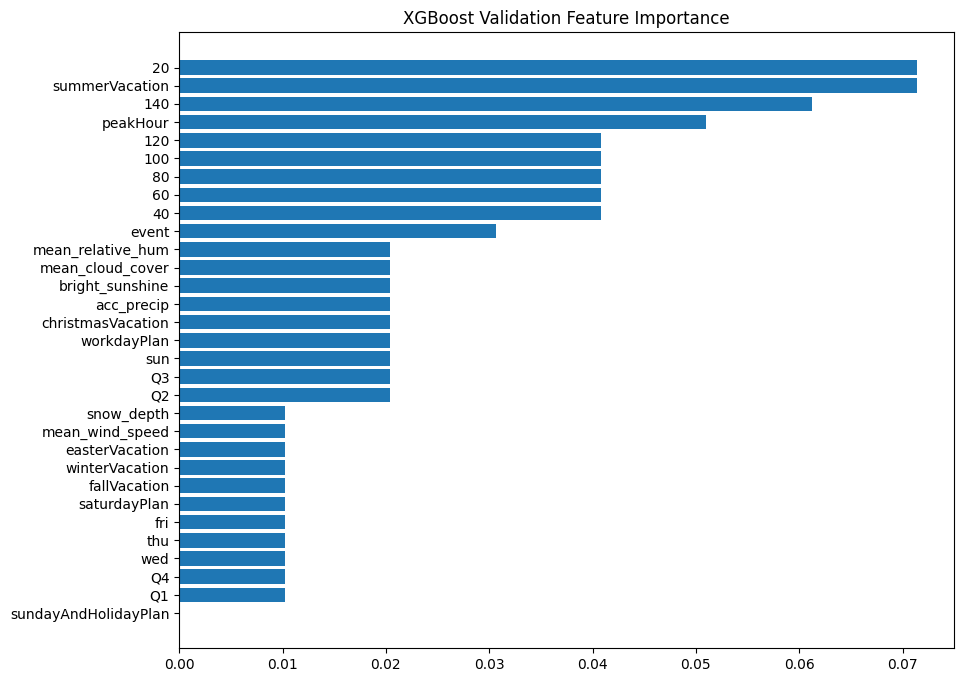

In [5]:
# XGBoost
laglist = [20, 40, 60, 80, 100, 120, 140]
model = XGBRegressor(n_estimators=50, alpha=0.1, eta=0.1, seed=42)

horizon = 40*agg
differentiation = None
scalar = StandardScaler()
exog_scalar = StandardScaler()

window_type = 'fixed'
window_size = None
use_exog = True
interval = None

names_to_ignore = [Columns.calendar_fallVacation.value, Columns.calendar_easterVacation.value, Columns.calendar_summerVacation.value,
                   Columns.calendar_winterVacation.value, Columns.calendar_christmasVacation.value,
                   Columns.calendar_Q1.value, Columns.calendar_Q2.value, Columns.calendar_Q3.value, Columns.calendar_Q4.value,
                   Columns.calendar_workdayPlan.value, Columns.calendar_saturdayPlan.value, Columns.calendar_sundayAndHolidayPlan.value]

X_train_temp = copy(X_train)
X_val_temp = copy(X_val)
while True:
    # find feature importances
    _, fi_loco_val = utils.Sklearn.loco_feature_importance(X_train_temp, y_train, X_val_temp, y_val, 
                                            model, laglist, horizon, differentiation, 
                                            scalar, exog_scalar, window_type, window_size, use_exog, interval)
    # find low importance features
    feature_score_worst = 10000
    feature_name_worst = None
    for feature_name, feature_score in fi_loco_val.items():
        if feature_score < feature_score_worst and feature_name not in names_to_ignore:
            feature_score_worst = feature_score
            feature_name_worst = feature_name
    # stop if all are significant or drop features
    if feature_score_worst > 0.0:
        break
    else:
        # ensure that unused variables are not dropped
        X_train_temp = X_train_temp.drop(columns=feature_name_worst)
        X_val_temp = X_val_temp.drop(columns=feature_name_worst)
        print('Dropped feature:', feature_name_worst)

fi_loco_val

utils.tools.plotFeatureImportance(fi_loco_val, 'XGBoost')

# Out of sample Shapley Variable Importance (oShapely-VI)

In [3]:
import os
from anatomy import *

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# define model methods
def train_lasso(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    lasso_model = Lasso(alpha=0.005, fit_intercept=True, random_state=42)
    lasso_model.fit(x_train, y_train)

    def pred_fn_lasso(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(lasso_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_lasso)

def train_rf(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    rf_model = RandomForestRegressor(n_estimators=250, random_state=42)
    rf_model.fit(x_train, y_train)

    def pred_fn_rf(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(rf_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_rf)

def train_xgb(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    xgb_model = XGBRegressor(n_estimators=50, alpha=0.1, eta=0.1, seed=42)
    xgb_model.fit(x_train, y_train)

    def pred_fn_xgb(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        return np.array(xgb_model.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_xgb)

# data generation
def generate_data(n_predictors=3) -> [pd.DataFrame, AnatomySubsets]:
    xy = copy(pd.concat([X_train, X_val]))
    scalar = StandardScaler()
    xy = pd.DataFrame(scalar.fit_transform(xy), columns=xy.columns)

    xy['y'] = copy(pd.concat([y_train, y_val]))
    for i in [20, 40, 60, 80, 100, 120, 140]:
        xy[f'{i}'] = xy['y'].shift(periods=i).fillna(0)

    subsets = AnatomySubsets.generate(
        index=xy.index,
        initial_window=X_train.shape[0],
        estimation_type=AnatomySubsets.EstimationType.EXPANDING,
        periods=1,
        gap=0
    )

    return xy, subsets

# create Anatomy model
def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lasso":
            model = train_lasso(train.drop("y", axis=1), train["y"])
        if key.model_name == "rf":
            model = train_rf(train.drop("y", axis=1), train["y"])
        if key.model_name == "xgb":
            model = train_xgb(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["rf", "xgb", "lasso"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=10).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyML.bin"
    )

# perform anatomy
def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyML.bin")
    groups = {
        "rf": ["rf"],
        "xgb": ["xgb"],
        "lasso": ["lasso"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    pd.options.display.width = 0  # to print all columns

    tmpl = "contributions to %s:"
    anatomized_mae = anatomize_mae()
    print(tmpl % "mean absolute error")
    print(anatomized_mae, "\n")
    return anatomized_mae


# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
estimate_anatomy(xy, subsets)

# load anatomy bin and calculate shapley values
anatomized_mae = anatomize(xy, subsets)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed:  3.4min
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed:  3.6min
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed:  3.7min
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed:  6.6min
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed:  6.8min
[Parallel(n_jobs=11)]: Done  15 tasks      | elapsed:  

KeyboardInterrupt: 

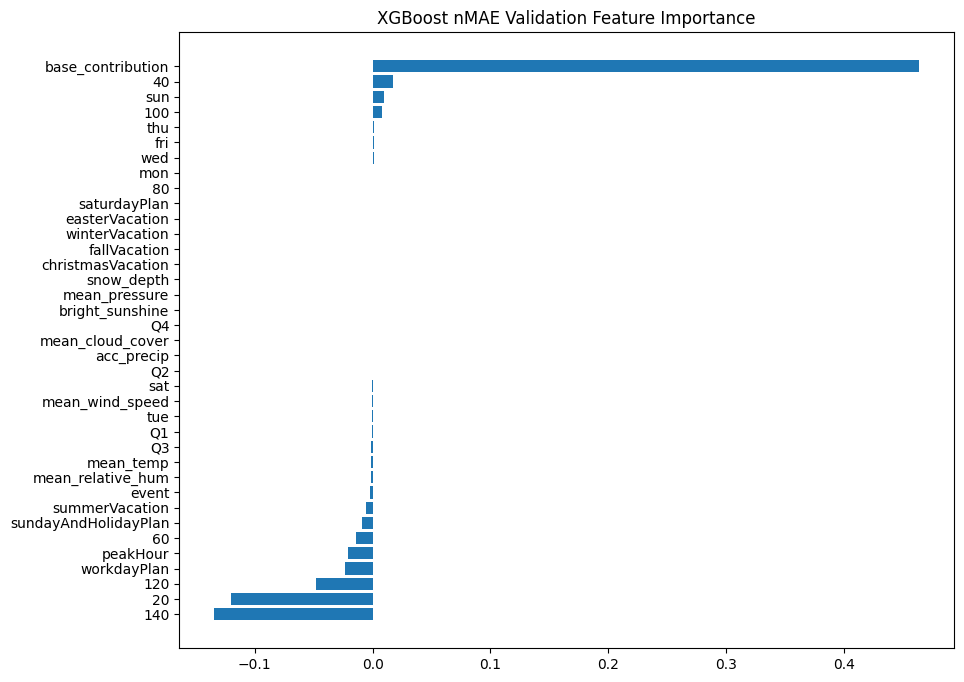

In [17]:
keys = anatomized_mae.transpose()['lasso']['14680 -> 16519'].index
values = anatomized_mae.transpose()['lasso']['14680 -> 16519'].to_list()
shapley_dict = dict(map(lambda i,j : (i,j), keys, values))

utils.tools.plotFeatureImportance(shapley_dict, 'XGBoost nMAE')